<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
Автор материала: Мария Мансурова, аналитик-разработчик в команде Яндекс.Метрики 
    
Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9. (демо)
## <center> Анализ временных рядов
    
**Заполните пропущенный код и ответьте на вопросы в [онлайн-форме](https://docs.google.com/forms/d/1ijk4aFKY5plPiI8z3Mgi3i1Ln94VBY9SSt6xGIdVVFQ/).**

In [28]:
import pandas as pd
import numpy as np
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

3.3.0


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [29]:
df = pd.read_csv('data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [30]:
df.shape

(383, 7)

In [31]:
df.date = pd.to_datetime(df.date)

In [32]:
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [33]:
from fbprophet import Prophet

In [34]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

In [35]:
m = Prophet()
m.fit(train_df);
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)
forecast.tail()

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yhat
378,2016-01-16,2979.319903,2962.206065,3000.758941,1719.875161,2524.111365,-861.693311,-861.693311,-861.693311,0.0,0.0,0.0,-861.693311,-861.693311,-861.693311,2117.626592
379,2016-01-17,2984.727592,2966.805250,3007.610604,1868.303086,2664.322639,-720.705354,-720.705354,-720.705354,0.0,0.0,0.0,-720.705354,-720.705354,-720.705354,2264.022238
380,2016-01-18,2990.135281,2970.720202,3014.353756,2886.162057,3666.712521,281.357669,281.357669,281.357669,0.0,0.0,0.0,281.357669,281.357669,281.357669,3271.492950
381,2016-01-19,2995.542971,2974.815851,3020.795385,3135.546525,3977.037481,541.423837,541.423837,541.423837,0.0,0.0,0.0,541.423837,541.423837,541.423837,3536.966808
382,2016-01-20,3000.950660,2978.779451,3027.306702,3011.530203,3845.452747,425.547911,425.547911,425.547911,0.0,0.0,0.0,425.547911,425.547911,425.547911,3426.498570


**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.
3426

Оценим качество предсказания по последним 30 точкам.

In [58]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE = ', np.mean(abs(cmp_df[-predictions:]['p'])))
print('MAE = ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE =  34.50292574049453
MAE =  599.8383194732162


**Вопрос 2**: Какое получилось MAPE?

**Вопрос 3**: Какое получилось MAE?

## Предсказываем с помощью ARIMA

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?
<br>Не стационарный, 0,107

0.1073921962761209


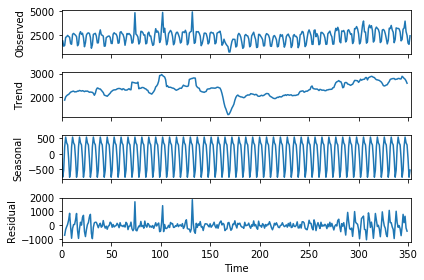

In [60]:
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print(sm.tsa.stattools.adfuller(train_df['y'])[1]); # p-value

In [61]:
train_df.set_index('ds', inplace=True)

0.0


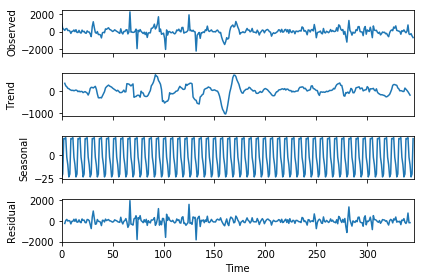

In [69]:
train_df['y_diff'] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, freq=7).plot();
print(round(sm.tsa.stattools.adfuller(train_df.y_diff[8:])[1], 5)); # p-v

**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?
<br>params (0, 1, 2, 3, 2, 1); <br>aic 4961.647147

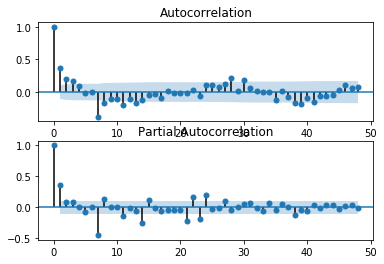

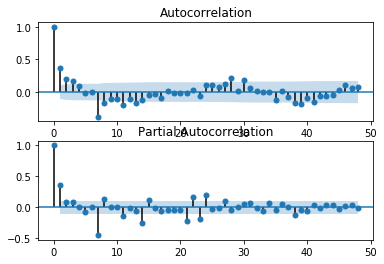

In [73]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

Q = 1; q = 3; P = 3; p = 1

In [102]:
ps = range(0, 2)
ds = range(0, 2)
qs = range(0, 4)
Ps = range(0, 4)
Ds = range(0, 3)
Qs = range(0, 2)

from itertools import product

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)

In [103]:
%%time
import warnings
from tqdm import tqdm
results1 = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

100%|██████████| 384/384 [09:41<00:00,  1.52s/it]

CPU times: user 23min 52s, sys: 52min 48s, total: 1h 16min 40s
Wall time: 9min 41s


In [104]:
result_table1 = pd.DataFrame(results1)
result_table1.columns = ['parameters', 'aic']
print(result_table1.sort_values(by = 'aic', ascending=True).head())

             parameters          aic
137  (0, 1, 2, 3, 2, 1)  4961.632628
271  (1, 1, 1, 3, 2, 1)  4962.830076
160  (0, 1, 3, 3, 2, 1)  4969.534608
181  (1, 0, 0, 3, 2, 1)  4973.212241
77   (0, 0, 3, 3, 2, 1)  4978.036900


In [106]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  353
Model:             SARIMAX(0, 1, 2)x(3, 2, 1, 7)   Log Likelihood               -2473.816
Date:                           Sun, 09 Dec 2018   AIC                           4961.633
Time:                                   15:02:58   BIC                           4988.394
Sample:                                        0   HQIC                          4972.298
                                           - 353                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5225      0.038    -13.807      0.000      -0.597      -0.448
ma.L2         -0.3271      0.044     -7.475      0.000      -0.413      -0.241
ar.S.L7       -0.6994      0.037    -18.998      0.000      -0.772      -0.627
ar.S.L14      -0.5112      0.053     -9.622      0.000      -0.615      -0.407
ar.S.L21      -0.3319      0.038     -8.816      0.000      -0.406      -0.258
ma.S.L7       -0.9833      0.097    -10.171      0.000      -1.173      -0.794
sigma2      1.189e+05    1.1e+04     10.775      0.000    9.73e+04    1.41e+05
===================================================================================
Ljung-Box (Q):                       51.17   Jarque-Bera (JB):               731.59
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             1.05
Prob(H) (two-sided):                  0.04   Kurtosis:                         9.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""